In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
plt.style.use('fivethirtyeight')

In [3]:
class EuroPmf(pd.Series):
    
    def update(self, data):
        for i in self.index:
            self.at[i] *= self.like(data, i)
        self *= 1 / self.sum()
    
    def update_set(self, *data):
        for datum in data:
            for i in self.index:
                self.at[i] *= self.like(datum, i)
        self *= 1 / self.sum()
    
    def like(self, data, i):
        if data == 'H':
            return i / 100.0
        else:
            return 1 - i / 100.0
        
    def credible_interval(self):
        cdf = self.cumsum()
        return tuple(cdf.index[cdf.searchsorted([0.05,0.95])])
    
    
class ExpEuroPmf(EuroPmf):
    
    def like(self, data, i):
        i /= 100.0
        h, t = data
        return i**h * (1-i)**t
        

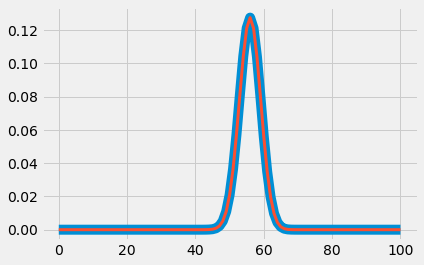

In [4]:
h, t = 140, 110

# with multiplication
euro = EuroPmf(1.0, index=range(0,101))
euro.update_set(*('T' * t + 'H' * h))
euro.plot(linewidth=10.0)

# with exponentiation
exp_euro = ExpEuroPmf(1.0, index=range(0, 101))
exp_euro.update((h,t))
euro.plot(linewidth=3.0)

In [5]:
print('maximum likelihood:', euro[(euro==euro.max())].index[0],
      exp_euro[(exp_euro==exp_euro.max())].index[0])
print('credible interval:',euro.credible_interval(),
      exp_euro.credible_interval())

maximum likelihood: 56 56
credible interval: (51, 61) (51, 61)


In [6]:
fair_likelihood = exp_euro.like((h,t), 50)
print('Likelihood of Fairness (p(Data|Fair)):',fair_likelihood)

Likelihood of Fairness (p(Data|Fair)): 5.527147875260445e-76


In [7]:
bias_likelihood = (exp_euro.like((h,t), 40) + exp_euro.like((h,t), 60)) / 2
print('Likelihood of Biasness (p(Data|Bias))',bias_likelihood)

Likelihood of Biasness (p(Data|Bias)) 7.357772729537146e-76


In [8]:
print('Bayes Factor:', bias_likelihood / fair_likelihood)

Bayes Factor: 1.3312060570100888


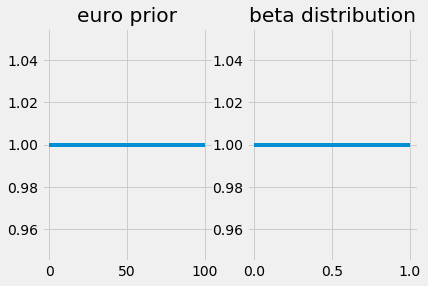

In [9]:
fig, axes = plt.subplots(1,2)
xs = np.linspace(0, 1, 101)
axes[0].set_title('euro prior')
axes[1].set_title('beta distribution')
axes[0].plot(EuroPmf(1.0, index=range(0,101)))
axes[1].plot(xs, stats.beta.pdf(xs, 1, 1))

In [10]:
class BetaCoin:
    
    def __init__(self, a, b):
        self.alpha = a
        self.beta = b
    
    def update(self, data):
        a, b = data
        self.alpha += a
        self.beta += b
        

Text(0.5,1,'Beta Euro Posterior')

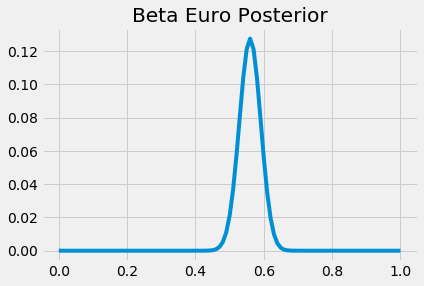

In [11]:
beta_euro = BetaCoin(1.0, 1.0)
beta_euro.update((h,t))
beta_euro_pdf = pd.Series([
    stats.beta.pdf(i, beta_euro.alpha, beta_euro.beta) for i in xs],
    index=xs)
beta_euro_pdf *= 1 / beta_euro_pdf.sum()
plot = beta_euro_pdf.plot()
plot.set_title('Beta Euro Posterior')

In [12]:
print('maximum likelihood:',beta_euro_pdf[(
    beta_euro_pdf==beta_euro_pdf.max())].index[0])

maximum likelihood: 0.56
